# OLG model
I assume the market completeness. For my future research, I don't solve the social planner's problem.

In this code, I don't consider
- individual uncertainty 
- life-time uncertainty 
- transitional dynamics

In [1]:
using BenchmarkTools
using Plots
Plots.plotlyjs

plotlyjs (generic function with 1 method)

In [2]:
mutable struct Model
    # primitive parameter
    beta::Float64 #subjective discount factor
    sigma::Float64 # relative risk aversion
    gamma::Float64 # weight on comsumption
    delta::Float64 #depriciation rate
    alpha::Float64 # capital share
    n::Float64 # pop growth
    tau::Float64 # ss tax

    # discretize asset space
    agrid::Array{Float64,1}
    # age productivity
    e::Array{Float64,1}
end


function OLG(m::Model)
    # preference
    const beta = m.beta
    const sigma = m.sigma 
    const gamma = m.gamma
    # production
    const alpha = m.alpha
    const delta = m.delta
    # demog
    const J = 66
    const JR = 46
    const tR = J-JR+1
    const tW = JR-1
    const n = m.n
    
    #ss 
    const tau = m.tau
    
    # measure
    mass::Array{Float64,1} = ones(J)
    for ik0 in 2:J
        mass[ik0]=mass[ik0-1]/(1.0+n)
    end
    # normalize
    mass = mass/sum(mass)
      
    #age efficiency
    e = m.e
    # create asset grid
    agrid = m.agrid
    const na = size(agrid,1)
    #penalty for negative consumption
    const neg = -1e10
    
    # initial guess
    K0 = 3.0
    L0 = 0.34
    
    
    v::Array{Float64,2} = zeros(na,J)
    pol_a::Array{Float64,2} = zeros(na,J)
    pol_lab::Array{Float64,2} = zeros(na,tW)
    a_index::Array{Int64,2} = ones(na,J)
    
    kgen::Array{Float64,2} = zeros(J,1)
    labgen::Array{Float64,2} = zeros(tW,1)
    
    # iteration set-up
    iter = 0
    maxiter = 100
    tolk = 1e-3
    tollab = 1e-3
    err_k = 10.0
    err_lab = 10.0
    
    # compute equilibrium
    while err_k> tolk || err_lab > tollab
        
        # factor price
        r0 = alpha*(K0^(alpha-1.0))*(L0^(1.0-alpha)) -delta
        w0 = (1.0-alpha)*(K0^(alpha))*(L0^(-alpha))
        
        #pension
        b = tau*w0*L0/(sum(mass[JR:end]))
    
        # backward induction
        
        
        # retired households
        
        # last period utility
        for ia0 in 1:na
            cons = (1.0+r0)*agrid[ia0] + b
            @inbounds v[ia0,J] = (cons^(1.0-sigma))/(1.0-sigma)
        end

        for j in J-1:-1:tW+1
            for ia0 in 1: na
                vmin = neg 
                for ia1 in 1:na
                    cons =(1.0+r0)*agrid[ia0] +b -agrid[ia1]
                    if cons<= 0.0
                        util = neg        
                    else
                        util = (cons^(1.0-sigma))/(1.0-sigma)
                    end
                    v0 = util + beta*v[ia1,j+1]
                    
                    if v0 > vmin
                        @inbounds v[ia0,j] = copy(v0)
                        @inbounds a_index[ia0,j] =ia1
                        vmin = copy(v0)
                    end
                end
            end
        end
        
        # working household
        for j in tW:-1:1
            for ia0 in 1 : na
                vmin = neg
                for ia1 in 1: na
                    lab =(gamma*(1.0-tau)*e[j]*w0-(1.0-gamma)*((1.0+r0)*agrid[ia0]-agrid[ia1]))/((1.0-tau)*e[j]*w0)
                    
                    # fesibility
                    if lab <0.0
                        lab =0.0
                    elseif lab > 1.0
                        lab =1.0
                    end
                    
                    cons =(1.0+r0)*agrid[ia0] + (1.0-tau)*w0*e[j]*lab - agrid[ia1]
                    
                    if cons<0.0
                        util =neg
                    else
                        util =(((cons^gamma)*(1.0-lab)^(1-gamma))^(1.0-sigma))/(1.0-sigma)
                    end
                    
                    v0 = util + beta*v[ia1,j+1]
                    if v0 > vmin
                        @inbounds v[ia0,j] = v0
                        @inbounds a_index[ia0,j] = ia1
                        @inbounds pol_lab[ia0,j] = lab
                        vmin = copy(v0)
                    end
                end
            end
        end
        

        
        #println(a_index[:,J])
        ia0 = 1
        for j in 1:J
            
            ia1 = a_index[ia0,j]
            @inbounds kgen[j] = agrid[ia1]
            if j <= tW
                @inbounds labgen[j] = pol_lab[ia0,j]*e[j]
            end
            ia0 = ia1
            #println(j)
        end
        
        for j in 1:J
            for ia0 in 1:na
                @inbounds pol_a[ia0,j] = agrid[a_index[ia0,j]]
            end
        end
        K1 = dot(kgen,mass)
        L1 = dot(labgen, mass[1:tW])
        
        K0 = 0.9*K0 + 0.1*K1
        L0 = 0.9*L0 + 0.1*L1
        
        err_k =abs(K0-K1)
        err_lab = abs(L0-L1)
        iter += 1
        if iter > maxiter
            println("the model cannot converge in $maxiter times iteration")
            break
        end
        #println("the number of iteration is $iter")
        #println("iter, $iter, error K, $err_k, error L, $err_lab")
        
    end
    #println("K is $K0, L is $L0")
    return(K0, L0,pol_a,pol_lab, v, agrid)
    
end
                
                
                        
                                  
                    

OLG (generic function with 1 method)

In [3]:
# preference
beta = 0.97
sigma = 2.0
gamma = 0.42
# production
alpha = 0.36
delta = 0.06
#popgrowth
n = 0.011
#ss tax    
tau = 0.11
# create asset grid
amax = 14.0
amin = 0.01
na = 180
agrid = linspace(amin,amax,na)
# age efficiency
e = zeros(45)
e[1:11]  = linspace(0.6, 1.0, 11)
e[11:21] = linspace(1.0, 1.08, 11)
e[21:31] = linspace(1.08, 1.12, 11)
e[31:41] = linspace(1.12, 1.06, 11)
e[41:45] = linspace(1.06, 1.02, 5)

model = Model(beta, sigma, gamma, delta, alpha, n, tau, agrid, e)

Model(0.97, 2.0, 0.42, 0.06, 0.36, 0.011, 0.11, [0.01, 0.0881564, 0.166313, 0.244469, 0.322626, 0.400782, 0.478939, 0.557095, 0.635251, 0.713408  …  13.2966, 13.3747, 13.4529, 13.5311, 13.6092, 13.6874, 13.7655, 13.8437, 13.9218, 14.0], [0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96  …  1.09, 1.084, 1.078, 1.072, 1.066, 1.06, 1.05, 1.04, 1.03, 1.02])

In [4]:
@time K,L,pol_a,pol_lab,v0,agrid =OLG(model)

  2.751412 seconds (125.90 k allocations: 6.649 MiB)


(2.9820880778703502, 0.34925529095095964, [0.01 0.01 … 0.01 0.01; 0.01 0.01 … 0.01 0.01; … ; 13.7655 13.7655 … 7.04408 0.01; 13.8437 13.8437 … 7.12223 0.01], [0.419755 0.41977 … 0.776839 0.816385; 0.356559 0.360524 … 0.775724 0.815259; … ; 0.0 0.0 … 0.221407 0.21946; 0.0 0.0 … 0.220292 0.218334], [-54.6002 -53.9795 … -8.82664 -4.37874; -54.3802 -53.7775 … -7.59216 -3.23653; … ; -36.788 -36.5086 … -0.262433 -0.068612; -36.722 -36.4431 … -0.261009 -0.0682347], [0.01, 0.0881564, 0.166313, 0.244469, 0.322626, 0.400782, 0.478939, 0.557095, 0.635251, 0.713408  …  13.2966, 13.3747, 13.4529, 13.5311, 13.6092, 13.6874, 13.7655, 13.8437, 13.9218, 14.0])

In [5]:
@benchmark OLG(model)

BenchmarkTools.Trial: 
  memory estimate:  451.03 KiB
  allocs estimate:  55
  --------------
  minimum time:     2.540 s (0.00% GC)
  median time:      2.548 s (0.00% GC)
  mean time:        2.548 s (0.00% GC)
  maximum time:     2.556 s (0.00% GC)
  --------------
  samples:          2
  evals/sample:     1


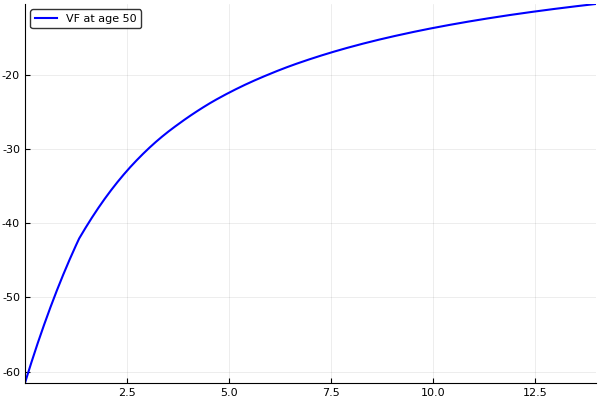

In [6]:
plot(agrid,v0[:,50],label="VF at age 50", color ="blue", linewidth=1.5)


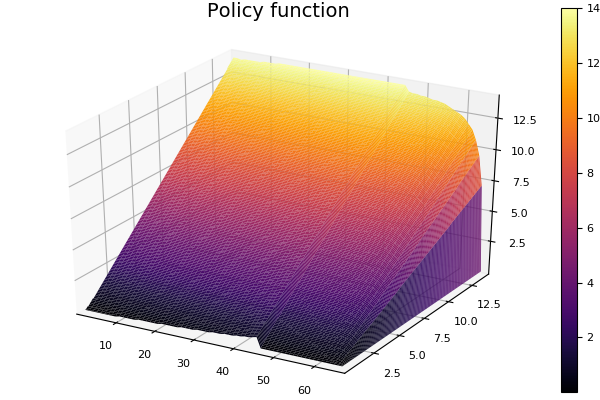

In [7]:
age = 1 : 66
Plots.surface(age,agrid,pol_a,title="Policy function")